In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**SCALOGRAM**

---------------------------------------------------------------------

Epoch 1/50
416/416 [==============================] - 107s 253ms/step - loss: 2.0220 - accuracy: 0.2345 - val_loss: 1.8064 - val_accuracy: 0.3249 - lr: 0.0010
Epoch 2/50
416/416 [==============================] - 101s 242ms/step - loss: 1.5909 - accuracy: 0.4170 - val_loss: 1.3619 - val_accuracy: 0.5058 - lr: 0.0010
Epoch 3/50
416/416 [==============================] - 100s 241ms/step - loss: 1.2713 - accuracy: 0.5388 - val_loss: 1.1118 - val_accuracy: 0.6025 - lr: 0.0010
Epoch 4/50
416/416 [==============================] - 101s 242ms/step - loss: 1.1037 - accuracy: 0.6058 - val_loss: 1.0063 - val_accuracy: 0.6347 - lr: 0.0010
Epoch 5/50
416/416 [==============================] - 100s 241ms/step - loss: 0.9835 - accuracy: 0.6505 - val_loss: 0.9325 - val_accuracy: 0.6684 - lr: 0.0010
Epoch 6/50
416/416 [==============================] - 100s 240ms/step - loss: 0.8951 - accuracy: 0.6819 - val_loss: 0.8550 - val_accuracy: 0.6974 - lr: 0.0010
Epoch 7/50
416/416 [==========================

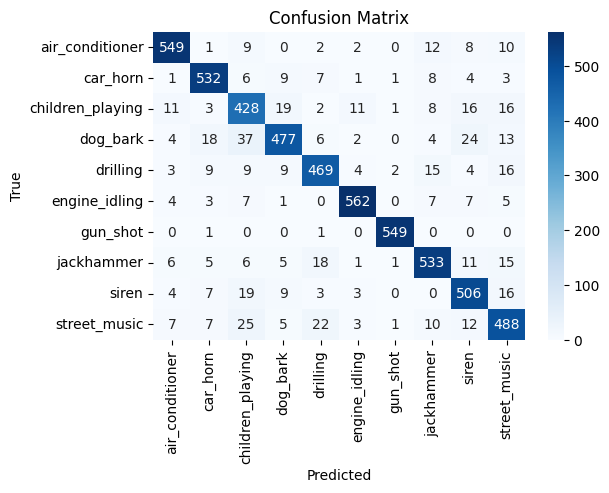

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract scalogram
def extract_scalogram(audio_file):
    audio, sr = librosa.load(audio_file, sr=44100)
    wavelet = librosa.cqt(audio, sr=sr)
    scalogram = librosa.amplitude_to_db(np.abs(wavelet), ref=np.max)
    scalogram = np.resize(scalogram, (128, 128))  # Resize for AlexNet
    return scalogram

# Load dataset without metadata, using folder names as labels
def load_data_from_folders(audio_path):
    X = []
    y = []
    class_labels = sorted(os.listdir(audio_path))  # Assuming folders represent classes

    for label in class_labels:
        label_folder = os.path.join(audio_path, label)
        if os.path.isdir(label_folder):
            for audio_file in os.listdir(label_folder):
                file_path = os.path.join(label_folder, audio_file)
                try:
                    features = extract_scalogram(file_path)
                    X.append(features)
                    y.append(label)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

    return np.array(X), np.array(y)

# Define input shape and number of classes
input_shape = (128, 128, 1)  # Scalogram as a single-channel input
audio_path = '/content/drive/MyDrive/Urban sound 4sec(38k)'  # Update with scalogram folder path
num_classes = len(os.listdir(audio_path))  # Number of classes based on folder count

# Load data
X, y = load_data_from_folders(audio_path)
X = X[..., np.newaxis]  # Add channel dimension

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Define AlexNet-type CNN model for scalogram
def build_alexnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Layer 1: Convolution + Max Pooling
    x = Conv2D(96, (11, 11), strides=4, activation='relu', padding='same')(inputs)
    x = MaxPooling2D((3, 3), strides=2)(x)

    # Layer 2: Convolution + Max Pooling
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=2)(x)

    # Layer 3-5: Convolution layers
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=2)(x)

    # Flatten and Dense layers
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and compile the model
model = build_alexnet_model(input_shape, num_classes)

# Callbacks for early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    batch_size=64,  # Adjust based on available GPU memory
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification report and confusion matrix for model evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix visualization
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
